In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
x = np.hstack((aa, hh, bb))

In [14]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [15]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [16]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [17]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [18]:
y.shape

(144, 2)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [20]:
x_train.shape

(100, 3)

In [21]:
y_train.shape

(100, 2)

In [22]:
tf.keras.backend.set_image_data_format('channels_last')

In [23]:
input_data = tf.keras.Input(shape=(input_size))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 128)               512       
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 128)               16512     
                                                                 
 outputLayer (Dense)         (None, 2)                 258   

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [26]:
model_directory = "D:\\TrainedModels\\20221124"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)

In [27]:
## Setting up callbacks
checkpoint_name = model_directory + '\\20221124ModelCheckpoint_MLP_test'+str(test_rate)+'_hAndBetaOnly.h5'
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
ckpt = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, save_best_only=True,
                                          monitor='loss', mode='min')
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=200, factor=0.5,
                                          min_delta = 1e-08, min_lr=1e-08,
                                          verbose=1)

In [28]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [29]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=10000, callbacks=[es, ckpt,rp])
end = datetime.datetime.now()

Epoch 1/10000
5/5 [==============================] - 1s 11ms/step - loss: 0.6022 - rmse: 0.7760 - lr: 0.0010
Epoch 2/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.2097 - rmse: 0.4579 - lr: 0.0010
Epoch 3/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.1164 - rmse: 0.3412 - lr: 0.0010
Epoch 4/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.0649 - rmse: 0.2548 - lr: 0.0010
Epoch 5/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.0484 - rmse: 0.2200 - lr: 0.0010
Epoch 6/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.0351 - rmse: 0.1873 - lr: 0.0010
Epoch 7/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.0268 - rmse: 0.1638 - lr: 0.0010
Epoch 8/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.0241 - rmse: 0.1554 - lr: 0.0010
Epoch 9/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.0219 - rmse: 0.1479 - lr: 0.0010
Epoch 10/10000
5/5 

Epoch 76/10000
5/5 [==============================] - 0s 29ms/step - loss: 0.0043 - rmse: 0.0654 - lr: 0.0010
Epoch 77/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0583 - lr: 0.0010
Epoch 78/10000
5/5 [==============================] - 0s 30ms/step - loss: 0.0034 - rmse: 0.0581 - lr: 0.0010
Epoch 79/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - rmse: 0.0611 - lr: 0.0010
Epoch 80/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0041 - rmse: 0.0641 - lr: 0.0010
Epoch 81/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0035 - rmse: 0.0589 - lr: 0.0010
Epoch 82/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0035 - rmse: 0.0595 - lr: 0.0010
Epoch 83/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0036 - rmse: 0.0604 - lr: 0.0010
Epoch 84/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0572 - lr: 0.0010
Epoch 85/10000


Epoch 149/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.3829e-04 - rmse: 0.0232 - lr: 0.0010
Epoch 150/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.7426e-04 - rmse: 0.0193 - lr: 0.0010
Epoch 151/10000
5/5 [==============================] - 0s 26ms/step - loss: 2.9075e-04 - rmse: 0.0171 - lr: 0.0010
Epoch 152/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.3949e-04 - rmse: 0.0155 - lr: 0.0010
Epoch 153/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.5415e-04 - rmse: 0.0159 - lr: 0.0010
Epoch 154/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.2855e-04 - rmse: 0.0151 - lr: 0.0010
Epoch 155/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.4906e-04 - rmse: 0.0158 - lr: 0.0010
Epoch 156/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.3757e-04 - rmse: 0.0184 - lr: 0.0010
Epoch 157/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.9488e-04

5/5 [==============================] - 0s 5ms/step - loss: 1.6403e-04 - rmse: 0.0128 - lr: 0.0010
Epoch 221/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4919e-04 - rmse: 0.0122 - lr: 0.0010
Epoch 222/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4402e-04 - rmse: 0.0120 - lr: 0.0010
Epoch 223/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.6621e-04 - rmse: 0.0129 - lr: 0.0010
Epoch 224/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1027e-04 - rmse: 0.0105 - lr: 0.0010
Epoch 225/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.1842e-04 - rmse: 0.0178 - lr: 0.0010
Epoch 226/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.3246e-04 - rmse: 0.0289 - lr: 0.0010
Epoch 227/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.1943e-04 - rmse: 0.0268 - lr: 0.0010
Epoch 228/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.5428e-04 - rmse: 0.0256 - l

5/5 [==============================] - 0s 5ms/step - loss: 2.4910e-04 - rmse: 0.0158 - lr: 0.0010
Epoch 293/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.7796e-04 - rmse: 0.0167 - lr: 0.0010
Epoch 294/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.2849e-04 - rmse: 0.0181 - lr: 0.0010
Epoch 295/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.5889e-04 - rmse: 0.0161 - lr: 0.0010
Epoch 296/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.9182e-04 - rmse: 0.0171 - lr: 0.0010
Epoch 297/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.3969e-04 - rmse: 0.0155 - lr: 0.0010
Epoch 298/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2991e-04 - rmse: 0.0152 - lr: 0.0010
Epoch 299/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2465e-04 - rmse: 0.0112 - lr: 0.0010
Epoch 300/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3950e-04 - rmse: 0.0118 - l

Epoch 364/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.3344e-05 - rmse: 0.0058 - lr: 0.0010
Epoch 365/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.3838e-05 - rmse: 0.0058 - lr: 0.0010
Epoch 366/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.2959e-05 - rmse: 0.0066 - lr: 0.0010
Epoch 367/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.5111e-05 - rmse: 0.0050 - lr: 0.0010
Epoch 368/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2828e-05 - rmse: 0.0048 - lr: 0.0010
Epoch 369/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.1317e-05 - rmse: 0.0046 - lr: 0.0010
Epoch 370/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.8966e-05 - rmse: 0.0054 - lr: 0.0010
Epoch 371/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.1744e-05 - rmse: 0.0056 - lr: 0.0010
Epoch 372/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.3482e-05 - 

Epoch 436/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.1132e-05 - rmse: 0.0056 - lr: 0.0010
Epoch 437/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.8073e-05 - rmse: 0.0043 - lr: 0.0010
Epoch 438/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.7733e-05 - rmse: 0.0042 - lr: 0.0010
Epoch 439/10000
5/5 [==============================] - 0s 34ms/step - loss: 1.5553e-05 - rmse: 0.0039 - lr: 0.0010
Epoch 440/10000
5/5 [==============================] - 0s 26ms/step - loss: 1.2438e-05 - rmse: 0.0035 - lr: 0.0010
Epoch 441/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4593e-05 - rmse: 0.0038 - lr: 0.0010
Epoch 442/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8754e-05 - rmse: 0.0043 - lr: 0.0010
Epoch 443/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.8807e-05 - rmse: 0.0054 - lr: 0.0010
Epoch 444/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8784e-05 

5/5 [==============================] - 0s 6ms/step - loss: 1.9389e-04 - rmse: 0.0139 - lr: 0.0010
Epoch 508/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.0666e-04 - rmse: 0.0144 - lr: 0.0010
Epoch 509/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8021e-04 - rmse: 0.0167 - lr: 0.0010
Epoch 510/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.1276e-04 - rmse: 0.0146 - lr: 0.0010
Epoch 511/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.7771e-04 - rmse: 0.0133 - lr: 0.0010
Epoch 512/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2657e-04 - rmse: 0.0151 - lr: 0.0010
Epoch 513/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8590e-04 - rmse: 0.0136 - lr: 0.0010
Epoch 514/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8435e-04 - rmse: 0.0136 - lr: 0.0010
Epoch 515/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.9796e-04 - rmse: 0.0141 - l

5/5 [==============================] - 0s 6ms/step - loss: 2.1452e-05 - rmse: 0.0046 - lr: 0.0010
Epoch 580/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.7865e-05 - rmse: 0.0042 - lr: 0.0010
Epoch 581/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.8510e-05 - rmse: 0.0043 - lr: 0.0010
Epoch 582/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3763e-05 - rmse: 0.0037 - lr: 0.0010
Epoch 583/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.7067e-05 - rmse: 0.0061 - lr: 0.0010
Epoch 584/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.8299e-05 - rmse: 0.0069 - lr: 0.0010
Epoch 585/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.0783e-05 - rmse: 0.0095 - lr: 0.0010
Epoch 586/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.2872e-05 - rmse: 0.0085 - lr: 0.0010
Epoch 587/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3060e-04 - rmse: 0.0114 - l

5/5 [==============================] - 0s 5ms/step - loss: 8.3546e-05 - rmse: 0.0091 - lr: 0.0010
Epoch 652/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.5103e-05 - rmse: 0.0074 - lr: 0.0010
Epoch 653/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.3768e-05 - rmse: 0.0080 - lr: 0.0010
Epoch 654/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.8817e-05 - rmse: 0.0062 - lr: 0.0010
Epoch 655/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.0409e-05 - rmse: 0.0064 - lr: 0.0010
Epoch 656/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.2649e-05 - rmse: 0.0079 - lr: 0.0010
Epoch 657/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0151e-04 - rmse: 0.0101 - lr: 0.0010
Epoch 658/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.4805e-05 - rmse: 0.0086 - lr: 0.0010
Epoch 659/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.7083e-05 - rmse: 0.0099 - l

5/5 [==============================] - 0s 6ms/step - loss: 5.8875e-06 - rmse: 0.0024 - lr: 5.0000e-04
Epoch 721/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.1145e-06 - rmse: 0.0025 - lr: 5.0000e-04
Epoch 722/10000
5/5 [==============================] - 0s 18ms/step - loss: 5.0136e-06 - rmse: 0.0022 - lr: 5.0000e-04
Epoch 723/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.0557e-06 - rmse: 0.0022 - lr: 5.0000e-04
Epoch 724/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.1176e-06 - rmse: 0.0023 - lr: 5.0000e-04
Epoch 725/10000
5/5 [==============================] - 0s 20ms/step - loss: 4.8070e-06 - rmse: 0.0022 - lr: 5.0000e-04
Epoch 726/10000
5/5 [==============================] - 0s 20ms/step - loss: 4.6446e-06 - rmse: 0.0022 - lr: 5.0000e-04
Epoch 727/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.1748e-06 - rmse: 0.0023 - lr: 5.0000e-04
Epoch 728/10000
5/5 [==============================] - 0s 6ms/step - 

5/5 [==============================] - 0s 6ms/step - loss: 2.7457e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 790/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.7220e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 791/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8650e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 792/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.2072e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 793/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.2387e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 794/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.5665e-06 - rmse: 0.0019 - lr: 5.0000e-04
Epoch 795/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.8197e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 796/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.0229e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 797/10000
5/5 [==============================] - 0s 5ms/step - los

5/5 [==============================] - 0s 6ms/step - loss: 1.2038e-05 - rmse: 0.0035 - lr: 5.0000e-04
Epoch 859/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4023e-05 - rmse: 0.0037 - lr: 5.0000e-04
Epoch 860/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.8076e-06 - rmse: 0.0028 - lr: 5.0000e-04
Epoch 861/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.5377e-06 - rmse: 0.0021 - lr: 5.0000e-04
Epoch 862/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.0552e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 863/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.8194e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 864/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.9063e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 865/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.6414e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 866/10000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 6ms/step - loss: 1.0415e-05 - rmse: 0.0032 - lr: 5.0000e-04
Epoch 928/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.7958e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 929/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.0615e-06 - rmse: 0.0022 - lr: 5.0000e-04
Epoch 930/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.8893e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 931/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.5611e-06 - rmse: 0.0024 - lr: 5.0000e-04
Epoch 932/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.9440e-06 - rmse: 0.0022 - lr: 5.0000e-04
Epoch 933/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.3038e-06 - rmse: 0.0021 - lr: 5.0000e-04
Epoch 934/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.4920e-06 - rmse: 0.0023 - lr: 5.0000e-04
Epoch 935/10000
5/5 [==============================] - 0s 6ms/step - los

5/5 [==============================] - 0s 5ms/step - loss: 2.9949e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 997/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.9134e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 998/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.9705e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 999/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.6204e-06 - rmse: 0.0019 - lr: 5.0000e-04
Epoch 1000/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.3045e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 1001/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.5306e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1002/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.8128e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 1003/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.6703e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1004/10000
5/5 [==============================] - 0s 5ms/step 

5/5 [==============================] - 0s 6ms/step - loss: 2.8066e-05 - rmse: 0.0053 - lr: 5.0000e-04
Epoch 1066/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.2684e-05 - rmse: 0.0048 - lr: 5.0000e-04
Epoch 1067/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.0005e-05 - rmse: 0.0032 - lr: 5.0000e-04
Epoch 1068/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6828e-05 - rmse: 0.0041 - lr: 5.0000e-04
Epoch 1069/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6997e-05 - rmse: 0.0041 - lr: 5.0000e-04
Epoch 1070/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3617e-05 - rmse: 0.0037 - lr: 5.0000e-04
Epoch 1071/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7596e-05 - rmse: 0.0042 - lr: 5.0000e-04
Epoch 1072/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2389e-05 - rmse: 0.0047 - lr: 5.0000e-04
Epoch 1073/10000
5/5 [==============================] - 0s 6ms/st

Epoch 1134/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.4594e-04 - rmse: 0.0121 - lr: 5.0000e-04
Epoch 1135/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.5873e-05 - rmse: 0.0093 - lr: 5.0000e-04
Epoch 1136/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.7822e-05 - rmse: 0.0061 - lr: 5.0000e-04
Epoch 1137/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.8104e-05 - rmse: 0.0069 - lr: 5.0000e-04
Epoch 1138/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.8159e-05 - rmse: 0.0083 - lr: 5.0000e-04
Epoch 1139/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.0180e-05 - rmse: 0.0071 - lr: 5.0000e-04
Epoch 1140/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.8698e-05 - rmse: 0.0094 - lr: 5.0000e-04
Epoch 1141/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.8071e-05 - rmse: 0.0076 - lr: 5.0000e-04
Epoch 1142/10000
5/5 [==========================

Epoch 1203/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8534e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 1204/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.4331e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1205/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8270e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 1206/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.2058e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 1207/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.1863e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 1208/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8257e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 1209/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.0353e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 1210/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8660e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 1211/10000
5/5 [==========================

Epoch 1269/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.3690e-07 - rmse: 7.9806e-04 - lr: 2.5000e-04
Epoch 1270/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.7815e-07 - rmse: 7.6036e-04 - lr: 2.5000e-04
Epoch 1271/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.9298e-07 - rmse: 7.7005e-04 - lr: 2.5000e-04
Epoch 1272/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.2502e-07 - rmse: 7.9058e-04 - lr: 2.5000e-04
Epoch 1273/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.5451e-07 - rmse: 8.0902e-04 - lr: 2.5000e-04
Epoch 1274/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.2357e-07 - rmse: 8.5063e-04 - lr: 2.5000e-04
Epoch 1275/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.8968e-07 - rmse: 8.3047e-04 - lr: 2.5000e-04
Epoch 1276/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.4706e-07 - rmse: 8.0440e-04 - lr: 2.5000e-04
Epoch 1277/10000

5/5 [==============================] - 0s 28ms/step - loss: 4.1841e-07 - rmse: 6.4684e-04 - lr: 2.5000e-04
Epoch 1336/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.2475e-07 - rmse: 7.2440e-04 - lr: 2.5000e-04
Epoch 1337/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.4237e-07 - rmse: 7.3646e-04 - lr: 2.5000e-04
Epoch 1338/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.8721e-07 - rmse: 8.2898e-04 - lr: 2.5000e-04
Epoch 1339/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.3830e-07 - rmse: 8.5924e-04 - lr: 2.5000e-04
Epoch 1340/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.9093e-07 - rmse: 7.6872e-04 - lr: 2.5000e-04
Epoch 1341/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.9325e-07 - rmse: 7.0232e-04 - lr: 2.5000e-04
Epoch 1342/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.4228e-07 - rmse: 7.3639e-04 - lr: 2.5000e-04
Epoch 1343/10000
5/5 [==========

5/5 [==============================] - 0s 6ms/step - loss: 5.7314e-07 - rmse: 7.5706e-04 - lr: 2.5000e-04
Epoch 1402/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.1510e-07 - rmse: 7.1770e-04 - lr: 2.5000e-04
Epoch 1403/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.5772e-07 - rmse: 6.7655e-04 - lr: 2.5000e-04
Epoch 1404/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.0167e-07 - rmse: 6.3378e-04 - lr: 2.5000e-04
Epoch 1405/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.2087e-07 - rmse: 6.4875e-04 - lr: 2.5000e-04
Epoch 1406/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.4670e-07 - rmse: 6.6835e-04 - lr: 2.5000e-04
Epoch 1407/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.4605e-07 - rmse: 6.6787e-04 - lr: 2.5000e-04
Epoch 1408/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.2417e-07 - rmse: 6.5129e-04 - lr: 2.5000e-04
Epoch 1409/10000
5/5 [===========

5/5 [==============================] - 0s 5ms/step - loss: 5.5198e-07 - rmse: 7.4295e-04 - lr: 2.5000e-04
Epoch 1468/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.2495e-07 - rmse: 7.9054e-04 - lr: 2.5000e-04
Epoch 1469/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.6436e-07 - rmse: 8.1508e-04 - lr: 2.5000e-04
Epoch 1470/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.7011e-07 - rmse: 7.5506e-04 - lr: 2.5000e-04
Epoch 1471/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.5806e-07 - rmse: 6.7680e-04 - lr: 2.5000e-04
Epoch 1472/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.0314e-07 - rmse: 7.7662e-04 - lr: 2.5000e-04
Epoch 1473/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.8036e-07 - rmse: 7.6181e-04 - lr: 2.5000e-04
Epoch 1474/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.5672e-07 - rmse: 7.4614e-04 - lr: 2.5000e-04
Epoch 1475/10000
5/5 [===========

5/5 [==============================] - 0s 6ms/step - loss: 2.0565e-05 - rmse: 0.0045 - lr: 2.5000e-04
Epoch 1536/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8085e-05 - rmse: 0.0043 - lr: 2.5000e-04
Epoch 1537/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.1008e-05 - rmse: 0.0078 - lr: 2.5000e-04
Epoch 1538/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.3664e-04 - rmse: 0.0117 - lr: 2.5000e-04
Epoch 1539/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0159e-04 - rmse: 0.0101 - lr: 2.5000e-04
Epoch 1540/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8647e-04 - rmse: 0.0137 - lr: 2.5000e-04
Epoch 1541/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.4540e-04 - rmse: 0.0157 - lr: 2.5000e-04
Epoch 1542/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.2216e-04 - rmse: 0.0179 - lr: 2.5000e-04
Epoch 1543/10000
5/5 [==============================] - 0s 6ms/st

5/5 [==============================] - 0s 5ms/step - loss: 9.1460e-07 - rmse: 9.5635e-04 - lr: 2.5000e-04
Epoch 1604/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.4328e-07 - rmse: 9.7123e-04 - lr: 2.5000e-04
Epoch 1605/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.8809e-07 - rmse: 8.2951e-04 - lr: 2.5000e-04
Epoch 1606/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.8849e-07 - rmse: 7.6713e-04 - lr: 2.5000e-04
Epoch 1607/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.0345e-07 - rmse: 7.7682e-04 - lr: 2.5000e-04
Epoch 1608/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.3802e-07 - rmse: 7.3350e-04 - lr: 2.5000e-04
Epoch 1609/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.5022e-07 - rmse: 7.4177e-04 - lr: 2.5000e-04
Epoch 1610/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.1349e-07 - rmse: 7.1659e-04 - lr: 2.5000e-04
Epoch 1611/10000
1/5 [=====>.....

5/5 [==============================] - 0s 6ms/step - loss: 3.2223e-07 - rmse: 5.6765e-04 - lr: 1.2500e-04
Epoch 1669/10000
5/5 [==============================] - 0s 22ms/step - loss: 3.0074e-07 - rmse: 5.4840e-04 - lr: 1.2500e-04
Epoch 1670/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.2579e-07 - rmse: 5.7078e-04 - lr: 1.2500e-04
Epoch 1671/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.5634e-07 - rmse: 5.9694e-04 - lr: 1.2500e-04
Epoch 1672/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.9654e-07 - rmse: 6.2971e-04 - lr: 1.2500e-04
Epoch 1673/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.6013e-07 - rmse: 6.0011e-04 - lr: 1.2500e-04
Epoch 1674/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.1502e-07 - rmse: 5.6127e-04 - lr: 1.2500e-04
Epoch 1675/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.0113e-07 - rmse: 5.4875e-04 - lr: 1.2500e-04
Epoch 1676/10000
5/5 [==========

5/5 [==============================] - 0s 6ms/step - loss: 3.2278e-07 - rmse: 5.6814e-04 - lr: 1.2500e-04
Epoch 1735/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.9765e-07 - rmse: 6.3059e-04 - lr: 1.2500e-04
Epoch 1736/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.3772e-07 - rmse: 5.8113e-04 - lr: 1.2500e-04
Epoch 1737/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.7552e-07 - rmse: 5.2490e-04 - lr: 1.2500e-04
Epoch 1738/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.0671e-07 - rmse: 5.5381e-04 - lr: 1.2500e-04
Epoch 1739/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.6767e-07 - rmse: 6.0636e-04 - lr: 1.2500e-04
Epoch 1740/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8364e-07 - rmse: 5.3258e-04 - lr: 1.2500e-04
Epoch 1741/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.8165e-07 - rmse: 5.3070e-04 - lr: 1.2500e-04
Epoch 1742/10000
5/5 [===========

5/5 [==============================] - 0s 29ms/step - loss: 1.9389e-07 - rmse: 4.4033e-04 - lr: 1.2500e-04
Epoch 1801/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.9871e-07 - rmse: 4.4576e-04 - lr: 1.2500e-04
Epoch 1802/10000
5/5 [==============================] - 0s 22ms/step - loss: 1.9081e-07 - rmse: 4.3682e-04 - lr: 1.2500e-04
Epoch 1803/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.9672e-07 - rmse: 4.4353e-04 - lr: 1.2500e-04
Epoch 1804/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.9175e-07 - rmse: 4.3790e-04 - lr: 1.2500e-04
Epoch 1805/10000
5/5 [==============================] - 0s 22ms/step - loss: 1.8064e-07 - rmse: 4.2502e-04 - lr: 1.2500e-04
Epoch 1806/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8710e-07 - rmse: 4.3255e-04 - lr: 1.2500e-04
Epoch 1807/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.9955e-07 - rmse: 4.4671e-04 - lr: 1.2500e-04
Epoch 1808/10000
5/5 [========

5/5 [==============================] - 0s 20ms/step - loss: 1.5820e-07 - rmse: 3.9775e-04 - lr: 1.2500e-04
Epoch 1867/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.7337e-07 - rmse: 4.1638e-04 - lr: 1.2500e-04
Epoch 1868/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.0475e-07 - rmse: 4.5249e-04 - lr: 1.2500e-04
Epoch 1869/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0580e-07 - rmse: 4.5365e-04 - lr: 1.2500e-04
Epoch 1870/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0934e-07 - rmse: 4.5754e-04 - lr: 1.2500e-04
Epoch 1871/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.1239e-07 - rmse: 4.6086e-04 - lr: 1.2500e-04
Epoch 1872/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.3523e-07 - rmse: 4.8500e-04 - lr: 1.2500e-04
Epoch 1873/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8226e-07 - rmse: 5.3128e-04 - lr: 1.2500e-04
Epoch 1874/10000
5/5 [==========

5/5 [==============================] - 0s 5ms/step - loss: 2.3256e-07 - rmse: 4.8225e-04 - lr: 1.2500e-04
Epoch 1933/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.3246e-07 - rmse: 5.7659e-04 - lr: 1.2500e-04
Epoch 1934/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.1170e-07 - rmse: 6.4164e-04 - lr: 1.2500e-04
Epoch 1935/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.2652e-07 - rmse: 7.9153e-04 - lr: 1.2500e-04
Epoch 1936/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.7341e-07 - rmse: 6.8805e-04 - lr: 1.2500e-04
Epoch 1937/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.0168e-06 - rmse: 0.0010 - lr: 1.2500e-04
Epoch 1938/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.2488e-07 - rmse: 9.6171e-04 - lr: 1.2500e-04
Epoch 1939/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.9854e-07 - rmse: 7.0607e-04 - lr: 1.2500e-04
Epoch 1940/10000
5/5 [===============

5/5 [==============================] - 0s 5ms/step - loss: 4.4420e-07 - rmse: 6.6648e-04 - lr: 1.2500e-04
Epoch 1999/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.3599e-07 - rmse: 6.6029e-04 - lr: 1.2500e-04
Epoch 2000/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.2663e-07 - rmse: 6.5317e-04 - lr: 1.2500e-04
Epoch 2001/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.1079e-07 - rmse: 7.8153e-04 - lr: 1.2500e-04
Epoch 2002/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.5996e-07 - rmse: 9.7977e-04 - lr: 1.2500e-04
Epoch 2003/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.4882e-06 - rmse: 0.0012 - lr: 1.2500e-04
Epoch 2004/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.8064e-06 - rmse: 0.0013 - lr: 1.2500e-04
Epoch 2005/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0126e-06 - rmse: 0.0010 - lr: 1.2500e-04
Epoch 2006/10000
5/5 [=======================

Epoch 2067/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.4309e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 2068/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.9371e-06 - rmse: 0.0028 - lr: 1.2500e-04
Epoch 2069/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.9800e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 2070/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.9338e-06 - rmse: 0.0024 - lr: 1.2500e-04
Epoch 2071/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.7063e-06 - rmse: 0.0022 - lr: 1.2500e-04
Epoch 2072/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.0792e-06 - rmse: 0.0023 - lr: 1.2500e-04
Epoch 2073/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.8938e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 2074/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6201e-05 - rmse: 0.0040 - lr: 1.2500e-04
Epoch 2075/10000
5/5 [==========================

5/5 [==============================] - 0s 6ms/step - loss: 2.1289e-07 - rmse: 4.6140e-04 - lr: 1.2500e-04
Epoch 2136/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.5896e-07 - rmse: 3.9870e-04 - lr: 1.2500e-04
Epoch 2137/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4276e-07 - rmse: 3.7784e-04 - lr: 1.2500e-04
Epoch 2138/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4239e-07 - rmse: 3.7734e-04 - lr: 1.2500e-04
Epoch 2139/10000
5/5 [==============================] - 0s 25ms/step - loss: 1.3606e-07 - rmse: 3.6886e-04 - lr: 1.2500e-04
Epoch 2140/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4165e-07 - rmse: 3.7637e-04 - lr: 1.2500e-04
Epoch 2141/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.0885e-07 - rmse: 4.5701e-04 - lr: 1.2500e-04
Epoch 2142/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.1838e-07 - rmse: 5.6425e-04 - lr: 1.2500e-04
Epoch 2143/10000
5/5 [==========

5/5 [==============================] - 0s 17ms/step - loss: 7.2694e-08 - rmse: 2.6962e-04 - lr: 6.2500e-05
Epoch 2201/10000
5/5 [==============================] - 0s 6ms/step - loss: 9.9537e-08 - rmse: 3.1549e-04 - lr: 6.2500e-05
Epoch 2202/10000
5/5 [==============================] - 0s 17ms/step - loss: 6.8025e-08 - rmse: 2.6082e-04 - lr: 6.2500e-05
Epoch 2203/10000
5/5 [==============================] - 0s 17ms/step - loss: 6.6459e-08 - rmse: 2.5780e-04 - lr: 6.2500e-05
Epoch 2204/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.6675e-08 - rmse: 2.7690e-04 - lr: 6.2500e-05
Epoch 2205/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.6442e-08 - rmse: 3.1055e-04 - lr: 6.2500e-05
Epoch 2206/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.9819e-08 - rmse: 2.8252e-04 - lr: 6.2500e-05
Epoch 2207/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.4327e-08 - rmse: 2.7263e-04 - lr: 6.2500e-05
Epoch 2208/10000
5/5 [========

In [30]:
time = end - start
print("Training time:", time)

Training time: 0:01:21.353113


In [31]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\20221124\\MLP_revised\\test"+str(test_rate)+"_hAndBetaOnly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

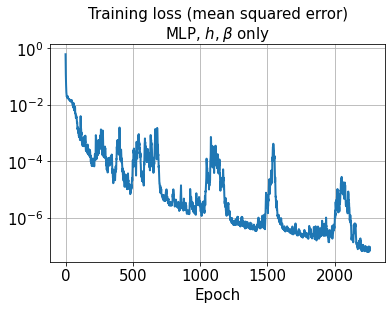

In [32]:
hist = history.history
plt.plot(hist['loss'], lw=2)
#plt.plot(hist['val_loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP, '+ r'$h, \beta$' + ' only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
#plt.legend(['Loss (MSE)', 'Validation loss'],loc ='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

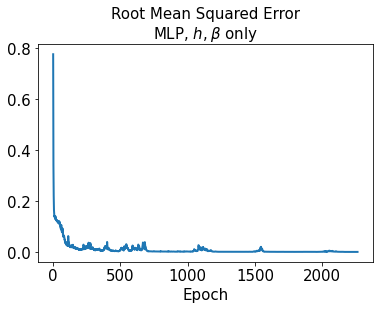

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, '+ r'$h, \beta$' + ' only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

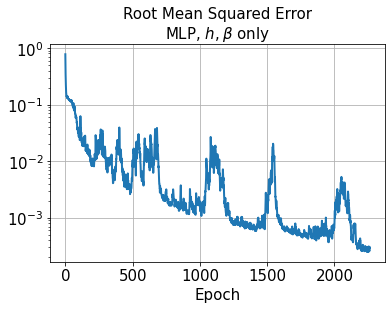

In [34]:
plt.plot(hist['rmse'], lw=2)
#plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, '+ r'$h, \beta$' + ' only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
#plt.legend(['RMSE', 'Validation RMSE'],loc ='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [35]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 3ms/step - loss: 5.1723e-07 - rmse: 7.1918e-04


In [36]:
test_results = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 1.9311e-04 - rmse: 0.0139


In [37]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

2/2 [==============================] - 0s 2ms/step


In [38]:
model_name = model_directory + "\\20221124steadyValidation_MLP_test"+str(test_rate)+ "_" + str(n_units) +"units_hBetaOnly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [39]:
error_train_abs = np.abs(decoded_train - y_train)

In [40]:
error_test_abs = np.abs(decoded_test - y_test)

In [41]:
os.chdir(storage_dir)

In [42]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0008150017994638367


In [43]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.017583315005902107


In [44]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.014696243734142122


In [45]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.0006012161127301938


In [46]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

0.07630889866514529


In [47]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.017410646634533167


In [48]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [49]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [50]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [51]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [52]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [53]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

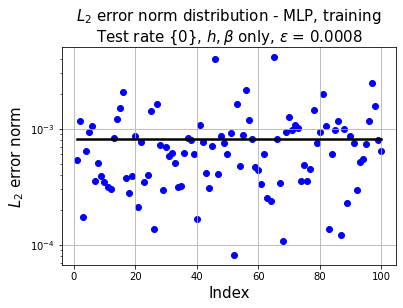

In [54]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nTest rate {0}, '+r'$h, \beta$'+' only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

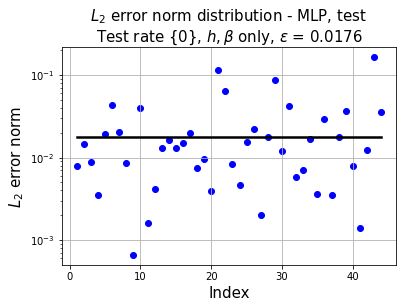

In [55]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nTest rate {0}, '+r'$h, \beta$'+' only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

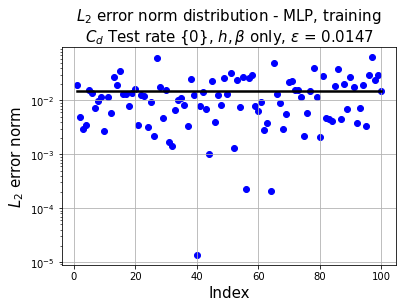

In [56]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_d$ Test rate {0}, '+r'$h, \beta$'+' only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

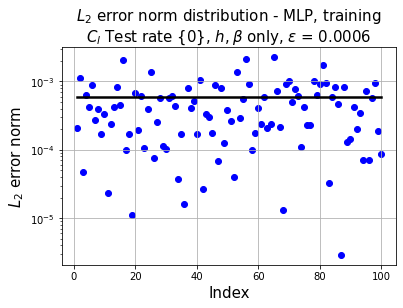

In [57]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_l$ Test rate {0}, '+r'$h, \beta$'+' only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

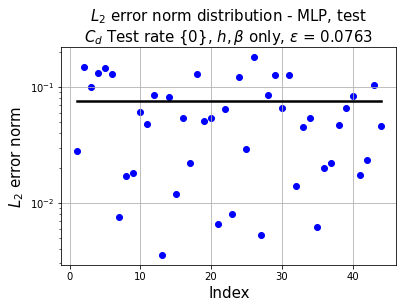

In [58]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_d$ Test rate {0}, '+r'$h, \beta$'+' only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

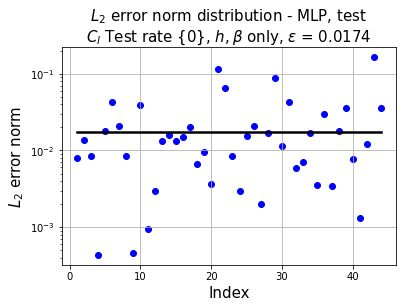

In [59]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_l$ Test rate {0}, '+r'$h, \beta$'+' only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [60]:
index_train = np.unique(np.where(np.isin(y, y_train)))
index_test = np.unique(np.where(np.isin(y, y_test)))
aa = aa*np.max(alpha)

In [61]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 15ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.0461, L2 error of Cl: 0.0167


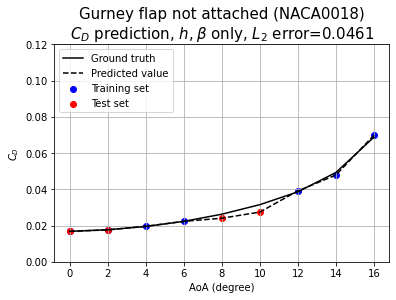

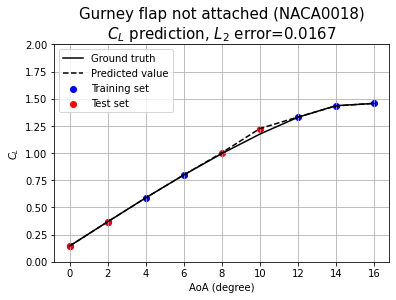

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0546, L2 error of Cl: 0.0079


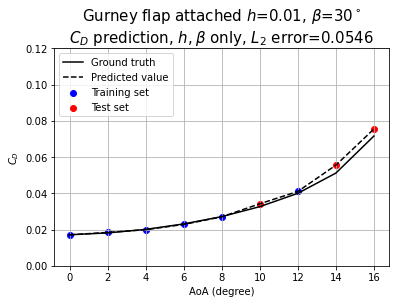

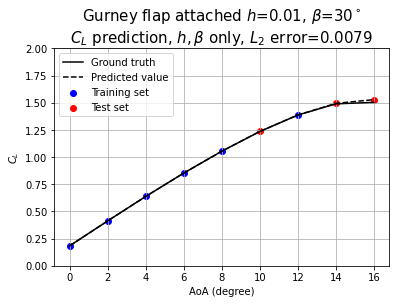

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0234, L2 error of Cl: 0.0089


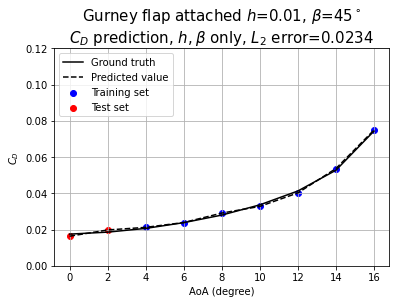

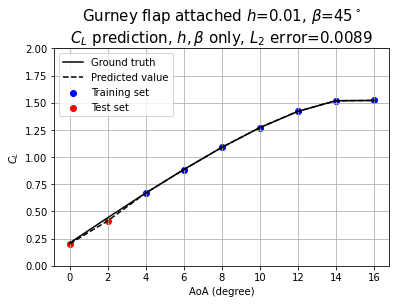

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0499, L2 error of Cl: 0.0142


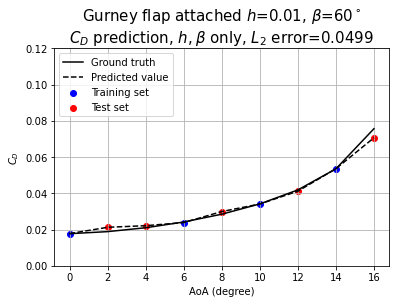

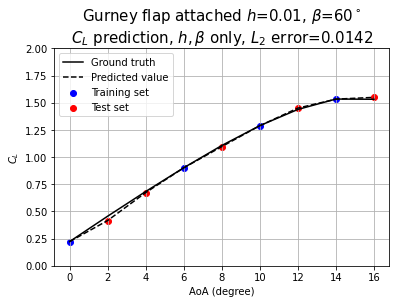

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0589, L2 error of Cl: 0.0166


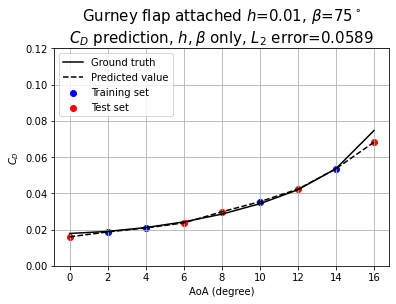

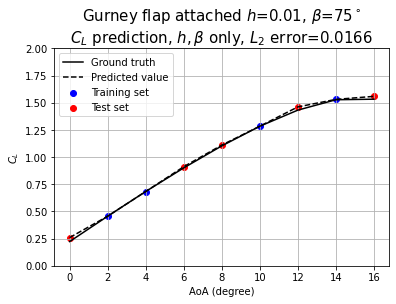

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0991, L2 error of Cl: 0.0133


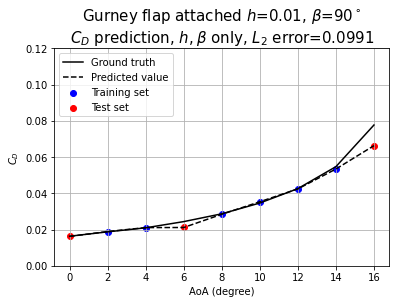

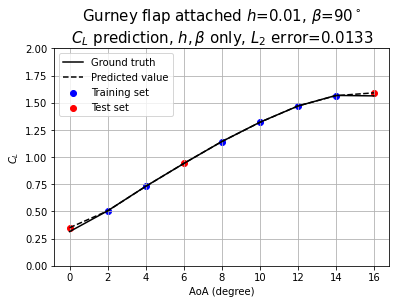

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0123, L2 error of Cl: 0.0067


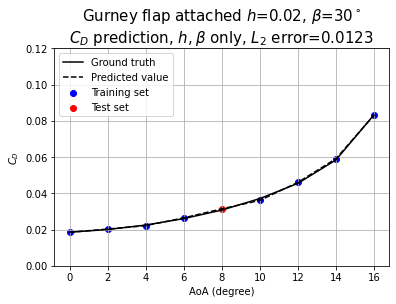

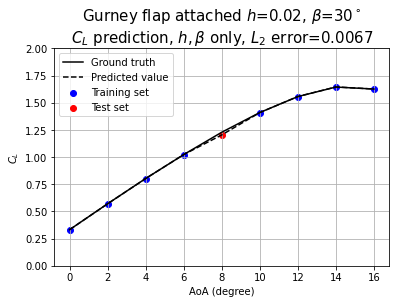

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0121, L2 error of Cl: 0.0057


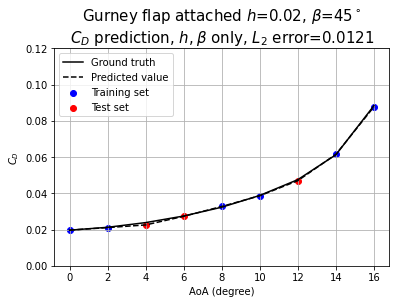

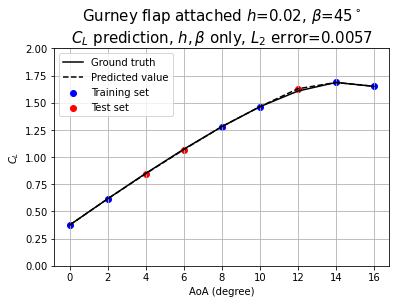

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0094, L2 error of Cl: 0.0066


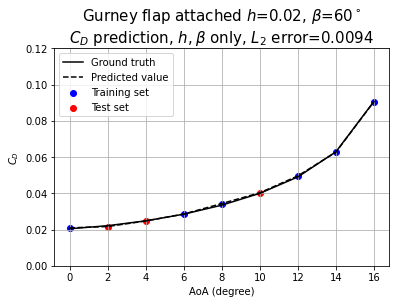

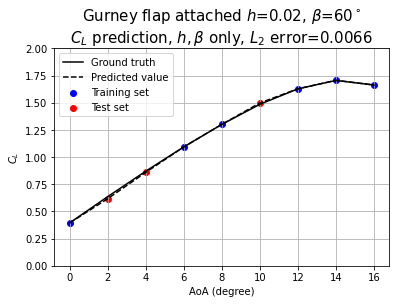

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0378, L2 error of Cl: 0.0025


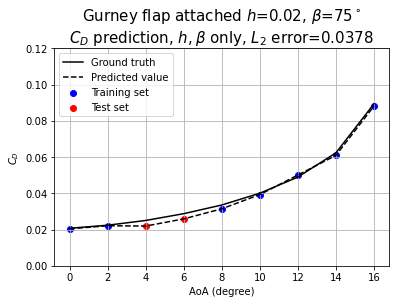

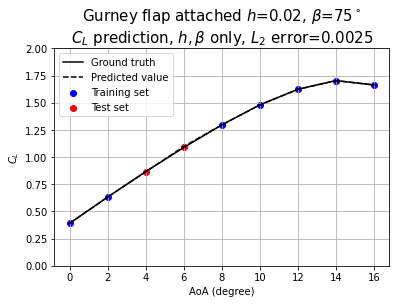

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0395, L2 error of Cl: 0.0066


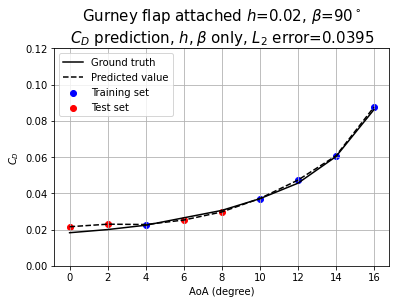

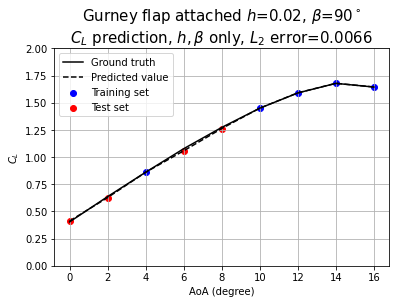

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0216, L2 error of Cl: 0.0076


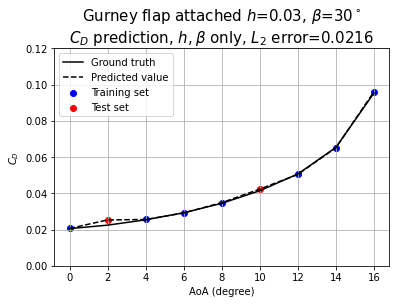

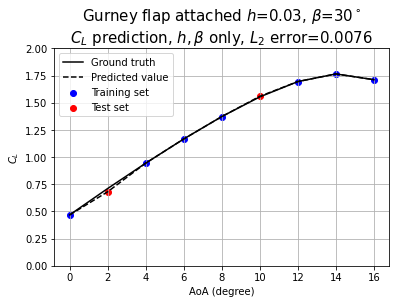

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0142, L2 error of Cl: 0.0083


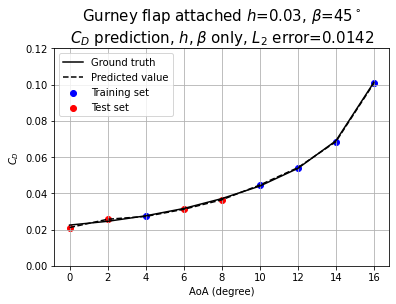

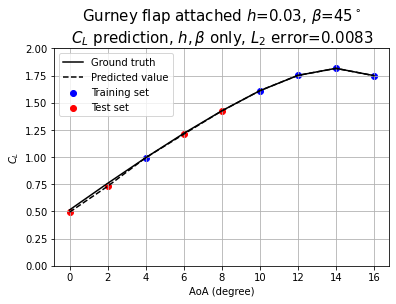

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0073, L2 error of Cl: 0.0039


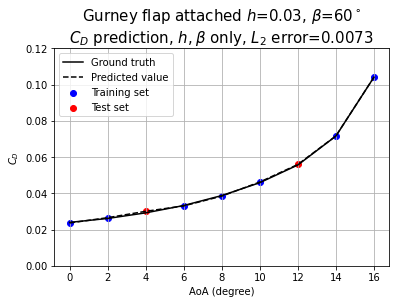

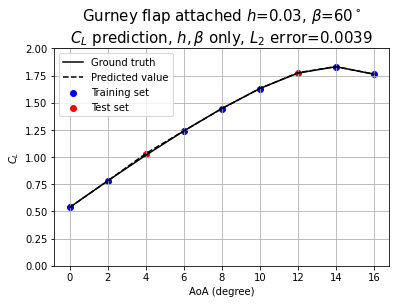

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0235, L2 error of Cl: 0.0039


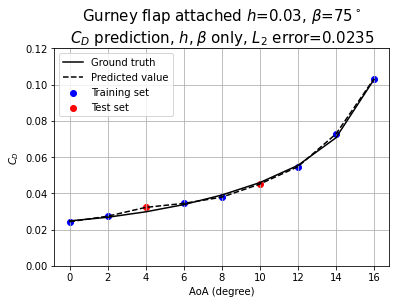

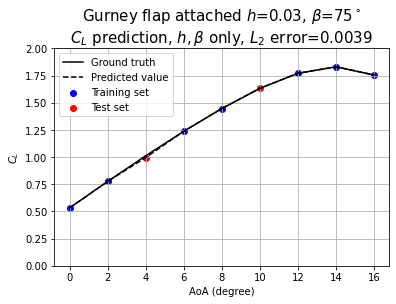

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0309, L2 error of Cl: 0.0017


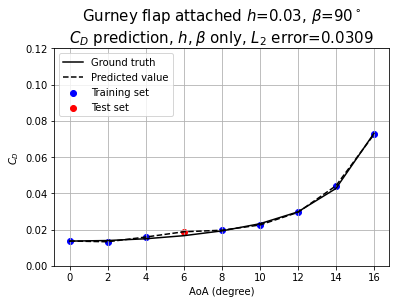

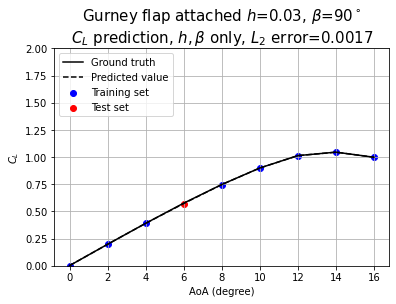

In [62]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    iTrain = []
    iTest = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue[:,1] - y_corres[:,1])**2) / np.sum(y_corres[:,1]**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    else:
        print('L2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1),1]
    cd = predicted[n_alpha*i:n_alpha*(i+1),0]
    
    CL = y[n_alpha*i:n_alpha*(i+1),1]
    CD = y[n_alpha*i:n_alpha*(i+1),0]
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])

    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)
    iTest = np.array(iTest)
    
    alpha_train = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)[:,0]
    aTest = np.array(alpha_test)[:,0]
    
    if i==0:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_D$ prediction, '+r'$h, \beta$'+' only, $L_2$ error=%.4f' % l2_error_Cd, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_NACA0018.jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_L$ prediction, $L_2$ error=%.4f' % l2_error_Cl, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_NACA0018.jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()
    
    else:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap attached $h$=%.2f, '%h[i] +r'$\beta$=%d$^\circ$'% beta[i]+'\n$C_D$ prediction, '+r'$h, \beta$'+' only, $L_2$ error=%.4f'%l2_error_Cd,
                  fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap attached $h$=%.2f, '%h[i] +r'$\beta$=%d$^\circ$'% beta[i]+'\n$C_L$ prediction, '+r'$h, \beta$'+' only, $L_2$ error=%.4f'%l2_error_Cl,
                  fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()